# Simple example of milestoning

Here we do milestoning on a double well potential and study the behavior of the mean first passage time.

In [1]:
%matplotlib inline
import milestoning

import numpy as np
import matplotlib.pyplot as plt
import scipy

np.set_printoptions(precision=4)

## Setting the system up

First, let us define our potential energy function.  It will be a double well potential with its shallowest well fixed at (-1, 0), the saddle point is at (0, `height`), and the deepest well is located at (1, `depth`).

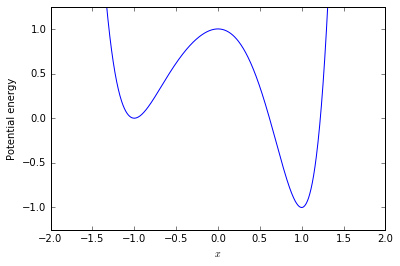

In [2]:
height = 1
depth = 1
potential = milestoning.Potential(height, depth)
potential.plot()

## Computing the mean first passage time from reactant to product.

There is a closed-form expression for the mean first passage time for one-dimensional systems (see also [1] for details). Indeed, the mean first passage time of a process initiated at $z$ and stopped whenever it exits the interval $(a, b)$ is given by
\begin{equation}
  \langle T \rangle = \int_a^b v(x; z) \, \mathrm{d} x,
\end{equation}
where the occupation density, $v$, is defined by
\begin{equation}
  v(x; z) = \beta \, \int_a^x \left( G(z) - H(\xi - z) \right) \mathrm{e}^{\beta (U(\xi) - U(x))} \, \mathrm{d} \xi,
  \quad \text{where} \quad
  G(z) = \frac{\int_{z}^b \mathrm{e}^{ \beta U(\eta) } \, \mathrm{d} \eta}{\int_a^b \mathrm{e}^{ \beta U(\eta) } \, \mathrm{d} \eta},
\end{equation}
and $H$ is the Heaviside step function.

Before computing the MFPT we need to specify some of the parameters required for the computation.

First, we specify the value of `a`, which is the leftmost point to be considered (the potential is such that the probability of finding the system beyond this point is negligible).
Next, we specify `b`, which is the position of the product state.
Finally, we set the location `z` of the reactant and the temperature through the variable `beta`.
The variable `q` determines the "mass" at the reactant state.

[1] Bello-Rivas, J. M., & Elber, R. (2016). Simulations of thermodynamics and kinetics on rough energy landscapes with milestoning. Journal of Computational Chemistry, 37(6), 602–613. [doi:10.1002/jcc.24039](doi:10.1002/jcc.24039)

In [3]:
a = -2
b = 3/4
z = -1

beta = 1

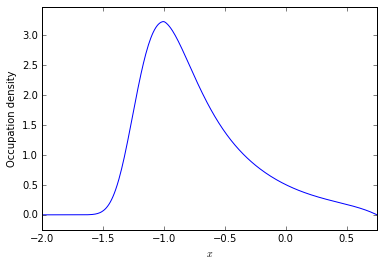

In [4]:
v = milestoning.OccupationDensity(potential, beta, a, b, z)
v.plot()

The mean first passage time is the integral of the occupation density.

In [5]:
results = scipy.integrate.quad(v, a, b, full_output=1, points=[z])
mfpt_reference = results[0]
print('The global mean first passage time is {}'.format(mfpt_reference))

The global mean first passage time is 2.636350336714919


## Comparison with milestoning

First we will define a set of milestones and then we will use the occupation density to compute the transition probabilities and the local mean first passage times.  Finally, we will obtain an estimate of the MFPT from reactant to product using the transition probabilities and the local MFPTs.

The $x$ coordinates of our milestones are the entries of the `milestones` array below.

In [6]:
M = 5   # Number of milestones
milestones = np.linspace(-1, 0.75, M)

print(milestones)

[-1.     -0.5625 -0.125   0.3125  0.75  ]


Observe that the reactant coincides with the first milestone and the product lies at the last milestone.

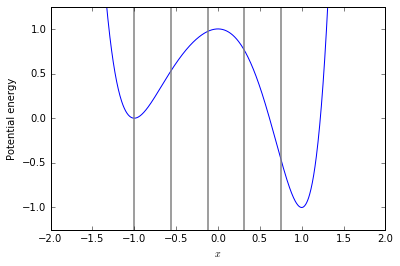

In [7]:
potential.plot()
for milestone in milestones:
    plt.axvline(milestone, color='gray', linewidth=1.5)

Now we will go through each milestone obtaining the transition probabilities and the local mean first passage times.

For a given milestone, $M_i$, the transition probability at each neighboring milestone, $M_j$ with $j = i \pm 1$, is defined as:
\begin{equation}
K_{i j} = \frac{\int\limits_{M_j} \frac{\partial v_i}{\partial n} \, \mathrm{d} \sigma}{\int\limits_{M_{i-1}} \frac{\partial v_i}{\partial n} \, \mathrm{d} \sigma + \int\limits_{M_{i+1}} \frac{\partial v_i}{\partial n} \, \mathrm{d} \sigma},
%K_{i j} = C_i^{-1} \, \int_{M_j} \frac{\partial v_i}{\partial n} \, \mathrm{d} \sigma,
\end{equation}
where $\frac{\partial v_i}{\partial n}$ denotes the normal derivative to the occupation density, $v_i$, on the subdomain spanning the interval $(M_{i-1}, M_{i+1})$.

### Compute the transition matrix and the vector of local mean first passage times.

We can use the formulation in terms of the occupation density above to obtain the entries of the transition matrix and the local MFPTs.  In this case, each milestone adopts the role of the reactant with its neighboring milestones becoming the product.

First, we initialize the transition matrix and the vector that will contain the local MFPTs.

In [8]:
K = np.zeros((M, M))
K[-1, 0] = 1

t = np.zeros((M,))

Next, we fill the entries of the transition matrix and compute the local MFPTs.

In [9]:
dx = 1e-3

for i, m in enumerate(milestones[:-1]):
    if i == 0:
        ai = a
    else:
        ai = milestones[i-1]
    bi = milestones[i+1]
    zi = milestones[i]

    print('Computing results for milestone #{} (x = {:.4f})'.format(i, zi))

    vi = milestoning.OccupationDensity(potential, beta, ai, bi, zi)

    y_prev = vi(ai + dx)
    y_next = vi(bi - dx)
    total = y_prev + y_next
    if i > 0:
        K[i, i-1] = y_prev / total
    K[i, i+1] = y_next / total
    
    t[i] = scipy.integrate.quad(vi, ai, bi, full_output=1, points=[zi])[0]

print('Done.')

Computing results for milestone #0 (x = -1.0000)
Computing results for milestone #1 (x = -0.5625)
Computing results for milestone #2 (x = -0.1250)
Computing results for milestone #3 (x = 0.3125)
Done.


### Compute the stationary flux vector.

Now that we have the transition matrix and the local mean first passage times, all that remains is to compute the stationary flux vector.

In [10]:
print(K)

[[ 0.      1.      0.      0.      0.    ]
 [ 0.6369  0.      0.3631  0.      0.    ]
 [ 0.      0.5376  0.      0.4624  0.    ]
 [ 0.      0.      0.3423  0.      0.6577]
 [ 1.      0.      0.      0.      0.    ]]


In [11]:
eigenvalues, eigenvectors = np.linalg.eig(K.T)
print(eigenvalues)

[ 1.0000+0.j     -0.7503+0.0527j -0.7503-0.0527j  0.2503+0.364j
  0.2503-0.364j ]


The dominant eigenvalue (the spectral radius) is equal to one.  The stationary flux vector is the unique eigenvector corresponding to the dominant eigenvalue.

In [12]:
dominant_eigenvalue_index = np.abs(eigenvalues - 1.0).argmin()
q = np.real(eigenvectors[:, dominant_eigenvalue_index])
q = q / np.linalg.norm(q, 1) * np.sign(sum(q))
print(q)

[ 0.3036  0.3952  0.1705  0.0788  0.0519]


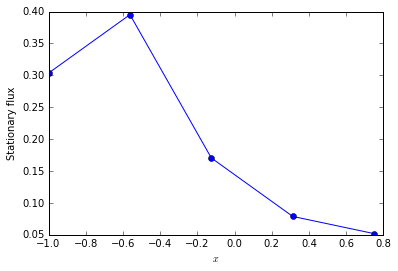

In [13]:
plt.plot(milestones, q, 'o-')
plt.xlabel('$x$')
plt.ylabel('Stationary flux')
plt.show()

The (global) mean first passage time can be readily obtained from the stationary flux vector and the local MFPTs.

In [14]:
mfpt_milestoning = np.dot(q, t) / q[-1]
print('MFPT (milestoning): {}\n'
      'MFPT (reference): {}'
      .format(mfpt_milestoning, mfpt_reference))

MFPT (milestoning): 2.638157217847497
MFPT (reference): 2.636350336714919


## Comparison with the true occupation density.

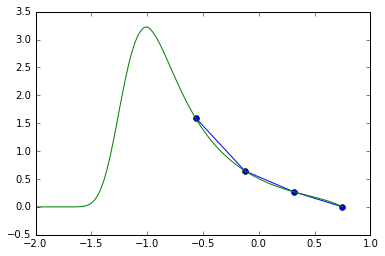

In [15]:
m = milestones
dm = np.diff(milestones)[0]

p = np.multiply(q, t)
p /= np.trapz(x=m, y=p, dx=dm)

x = np.linspace(a, b, 100)

alpha = v(m[-2]) / p[-2]

plt.plot(m[1:], alpha * p[1:], 'o-')
plt.plot(x, v(x))
plt.show()

## Comparison between the local MFPTs to those obtained by simulation using trajectories and those obtained by the quadrature formula.

In [16]:
from timestepper import FirstPassageTime

dt = 1e-4
num_trajectories = 1000

for i, m in enumerate(milestones[:-1]):
    if i == 0:
        ai = a
    else:
        ai = milestones[i-1]
    bi = milestones[i+1]
    zi = milestones[i]
  
    fpt = FirstPassageTime(potential, beta, dt, zi, ai, bi)
    mfpt = fpt.mean(num_trajectories)[0]
    print('Local MFPT at milestone #{} (x = {:.4f}): {:.4f} (Brownian dynamics) / {:.4f} (quadrature)'
          .format(i, zi, mfpt, t[i]))
    
print('Done.')

Local MFPT at milestone #0 (x = -1.0000): 0.2742 (Brownian dynamics) / 0.2628 (quadrature)
Local MFPT at milestone #1 (x = -0.5625): 0.0981 (Brownian dynamics) / 0.0914 (quadrature)
Local MFPT at milestone #2 (x = -0.1250): 0.0915 (Brownian dynamics) / 0.0861 (quadrature)
Local MFPT at milestone #3 (x = 0.3125): 0.0758 (Brownian dynamics) / 0.0783 (quadrature)
Done.
